## Fully Connected Convolutional Neural Network

In this notebook the previously used model is transformed in a Fully Fully Connected Convolutional Neural Network (FCN).

At first, the model is loaded and summarized to confirm correct procedure.

In [1]:
from os import path

import tensorflow as tf

model_path = path.join('models', 'symbol_classifier','model.h5')
old_model = tf.keras.models.load_model(model_path)

old_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 14,643
Trainable params: 14,643
Non-trainable params: 0
____________________________________________________

### Conversion into a FCN

Now the model is restructured into a FCN by adding an `input layer` which accepts a 2d input of arbitrary size.

The model is transformed using the [functional API](https://keras.io/getting-started/functional-api-guide/), where each layer is considered to be a function which is called by providing the previous layer as input.

The flatten layer was used to map the `Conv2D` layer onto the `Dense` output layer.
By transforming the output layer into a `Conv2D` layer with 3 filters (for 3 different classes),
we get the same result as by just scanning the model.

For this the input dimensions of the flattened layer (which is practically the "output shape" of the last `Conv2D` layer of the model) are used to determine the connections between the last `Conv2D` layer and the new output layer by reshaping the weights of the former output layer (please note that biases do not need a reshape).

Using the determined shape and weights a new `tf.keras.layers.Conv2D` layer is created.

In [2]:
inputs = tf.keras.Input(shape=(None, None, 1))

hidden = old_model.layers[0](inputs)

for layer in old_model.layers[1:4]:
    hidden = layer(hidden)

# Get the input dimensions of the flattened layer:
f_dim = old_model.layers[4].input_shape
# And use it to convert the next dense layer:
dense = old_model.layers[5]
out_dim = dense.get_weights()[1].shape[0]
W, b = dense.get_weights()
new_W = W.reshape((f_dim[1], f_dim[2], f_dim[3], out_dim))
outputs = tf.keras.layers.Conv2D(out_dim,
                           (f_dim[1], f_dim[2]),
                           name = dense.name,
                           strides = (1, 1),
                           activation = dense.activation,
                           padding = 'valid',
                           weights = [new_W, b])(hidden)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dense (Conv2D)               (None, None, None, 3)     6147      
Total params: 14,643
Trainable params: 14,643
Non-trainable params: 0
_________________________________________________________

### Loading the image

As before the same image is loaded using `cv2`.
The first advantage of FCN is that the image does not have to be cropped before being fed into the model.

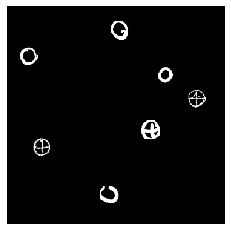

In [3]:
import cv2
from matplotlib import pyplot as plt

image_path = path.join('reports', 'sep', 'images', 'node_localization.png')
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.axis('off')
plt.set_cmap('gray')
plt.imshow(image)
plt.show()

## Taking the time

Since no further adjustments to the input data have to be done (except expanding the dimensions to match the expected input size), the time can be stopped.

The resulting `predictions` are in a different format, since they come directly in `[batch_idx, x, y, pred]`.

In [4]:
from time import time

image_exp = tf.expand_dims(tf.expand_dims(image, axis=-1), axis=0)
image_exp = tf.cast(image_exp / 255, tf.float32)

start = time()
predictions = model.predict(image_exp)
duration = time() - start

print("Finished after %.2f seconds." % duration)
print("\nShape of prediction:", predictions.shape)
print("\nFirst 5 predictions:")
print(predictions[0][0][:5])

Finished after 0.16 seconds.

Shape of prediction: (1, 83, 83, 3)

First 5 predictions:
[[0.95092016 0.01089852 0.03818127]
 [0.95484823 0.00888007 0.03627167]
 [0.95484823 0.00888007 0.03627167]
 [0.95484823 0.00888007 0.03627167]
 [0.95484823 0.00888007 0.03627167]]


## Showing the results

Another advantage of having everything in the same model and using the functional API is to be able is to be able to use `tf.keras.Lambda` layers.

`Lambda` layers enable the possibility to implement functions as layers, which is useful if we want to include the drawing of bounding boxes into the model.

The resulting model can be extended like this:

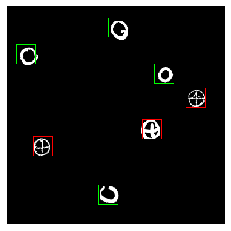

In [5]:
def get_bounding_boxes_nms(predictions):
    sqz = tf.squeeze
    max_idx = tf.math.argmax(sqz(predictions), -1)
    node_idx = tf.where(tf.equal(max_idx, 1))
    base_idx = tf.where(tf.equal(max_idx, 2))
    all_idx = tf.concat([node_idx, base_idx], 0)

    max_val = tf.math.reduce_max(sqz(predictions), -1)
    
    y, x = tf.split(all_idx * 4, 2, -1) # Times 4 to compensate model stride
    coords = sqz(tf.stack([y, x, y + 32, x + 32], -1))
    all_boxes = tf.cast(coords / 360, tf.float32)

    scores = tf.gather_nd(max_val, all_idx)
    eps = tf.keras.backend.epsilon()
    nms_idx = tf.image.non_max_suppression(all_boxes, scores, 99, eps, 0.5)

    limit = tf.cast(tf.math.count_nonzero(node_idx, 0)[0], tf.int32)
    mask = tf.less(nms_idx, limit)
    node_mask = tf.boolean_mask(nms_idx, mask)
    base_mask = tf.boolean_mask(nms_idx,~mask)

    node_boxes = tf.gather(all_boxes, node_mask)
    base_boxes = tf.gather(all_boxes, base_mask)

    return node_boxes, base_boxes

boxes_outputs = tf.keras.layers.Lambda(get_bounding_boxes_nms)(outputs)
boxes_model = tf.keras.Model(inputs = inputs, outputs = boxes_outputs)

node_boxes, base_boxes = boxes_model(image_exp)

image_rgb = tf.image.grayscale_to_rgb(image_exp)
image_boxes = tf.image.draw_bounding_boxes(image_rgb, [node_boxes], [[0, 1, 0]])
image_boxes = tf.image.draw_bounding_boxes(image_boxes, [base_boxes], [[1, 0, 0]])

plt.axis('off')
plt.set_cmap('hsv')
plt.imshow(tf.squeeze(image_boxes))
plt.show()

So the result is essentially the same, as it is classifying each symbol correctly.
The duration needed for this operation is again 10 times faster than using simple crops and feeding the to the model individually.

The output is easier to handle, since it already has a 2 dimensional format and does not need any processing.

At last, the models are saved to be usable later on.

In [6]:
model.save(path.join('models', 'devel','fcn_sym_det.h5'))